In [263]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [264]:
# Get the merged malware data
df = pd.read_csv("vt_reports/merge.csv")
df.head()

,sha256,first_submission_date,family
0,98f8e26e12b978102fa39c197f300ebe5fe535617737d5...,1630575593,tnega
1,7b2999ffadbc3b5b5c5e94145ca4e2f8de66ac1e3ddd52...,1629375559,quasar
2,e7569d494fe00be04ef6c9fcc5e54720c0df623b08e79d...,1362057319,pasta
3,1ed60c04f572b6acb9f64c31db55ef5c6b5465bd4da1eb...,1630624233,cjishu
4,4c4aaff20a57213d9a786e56ad22f1eaa94694a2f1042b...,1592186154,kingsoft


In [265]:
df_variances = pd.read_csv("variances.csv")
df_variances.head()

,Unnamed: 0,family,variance,families_perc
0,377,cobra,0.017703,0.001493
1,282,gendal,0.019088,0.004478
2,104,kiser,0.019088,0.004478
3,2,pasta,0.019434,0.007463
4,90,bestafera,0.019434,0.007463


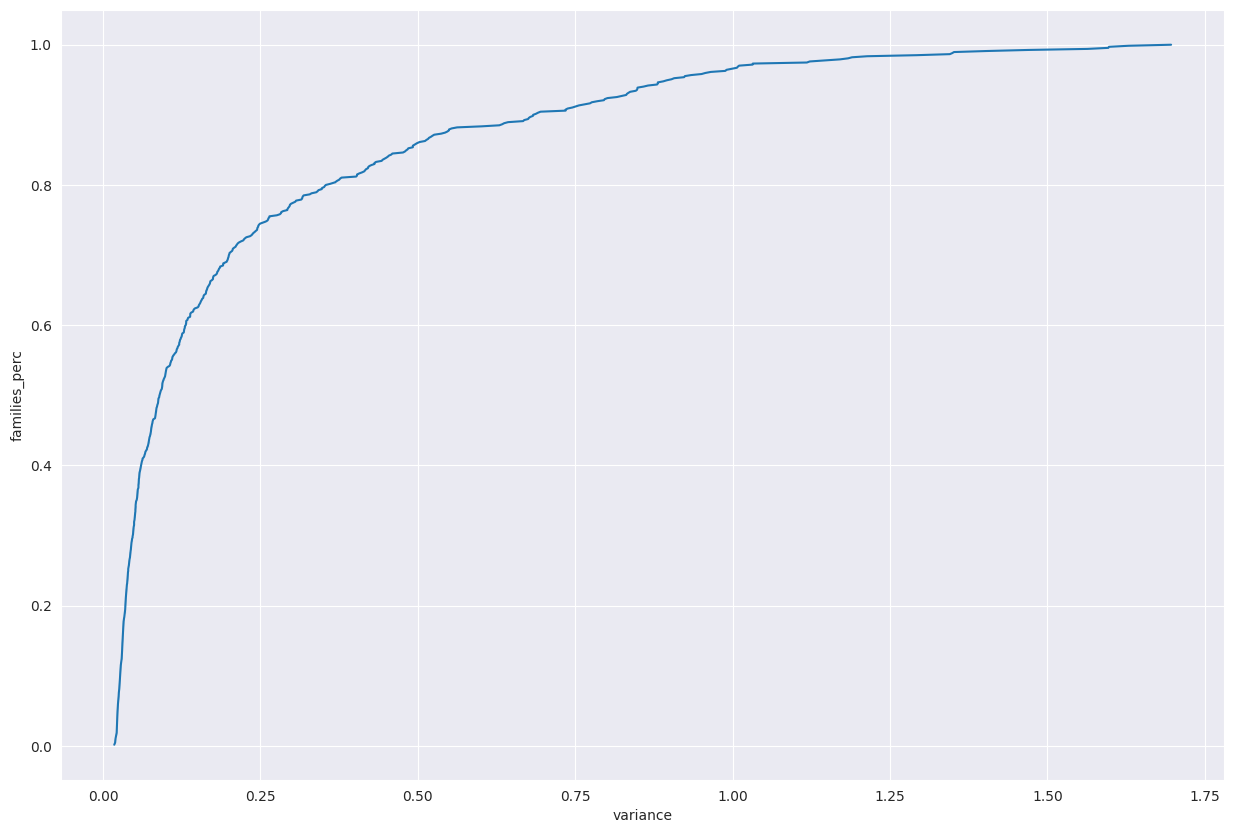

In [266]:
# Plot the distribution of first submissions over time
plt.figure(figsize=(15, 10))
sns.lineplot(df_variances, x="variance", y="families_perc")
plt.show()

In [267]:
df_variances = pd.DataFrame({"family": df_variances["family"], "variance": df_variances["variance"]})
df_variances_top = df_variances[df_variances["variance"] > 0.3].sort_values(by="variance", ascending=False)
families = df_variances_top["family"][:20]
df_variances_top.head()

,family,variance
669,balrok,1.696429
668,snojan,1.628920
667,griptolo,1.597762
666,stone,1.596723
665,daws,1.563488


In [268]:
# Extract the year from a timestamp t
def t_to_year(t):
    dt = pd.to_datetime(t, unit='s')
    return dt.year #pd.Timestamp(f"{dt.year}-{dt.month}")

df_dt = df.copy()
df_dt['first_submission_date'] = df['first_submission_date'].apply(lambda t: t_to_year(t))

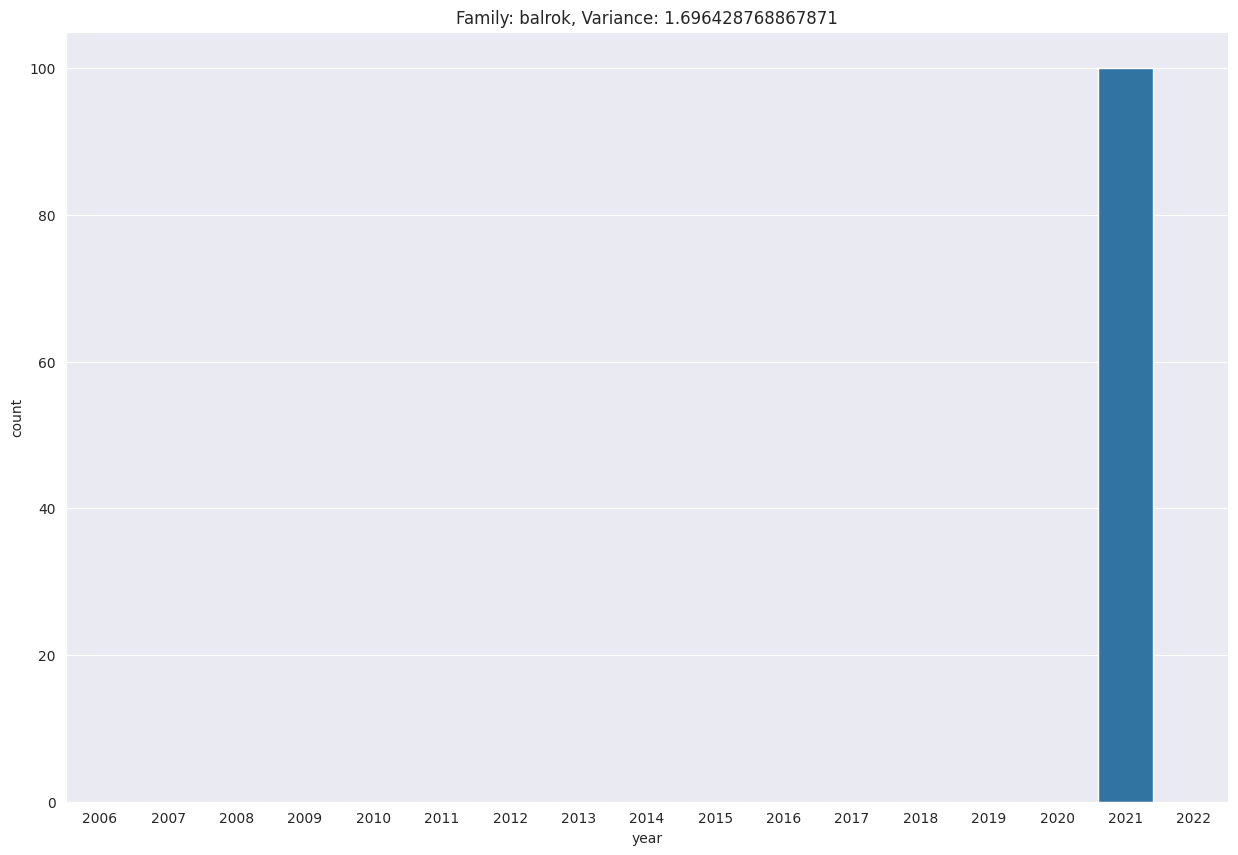

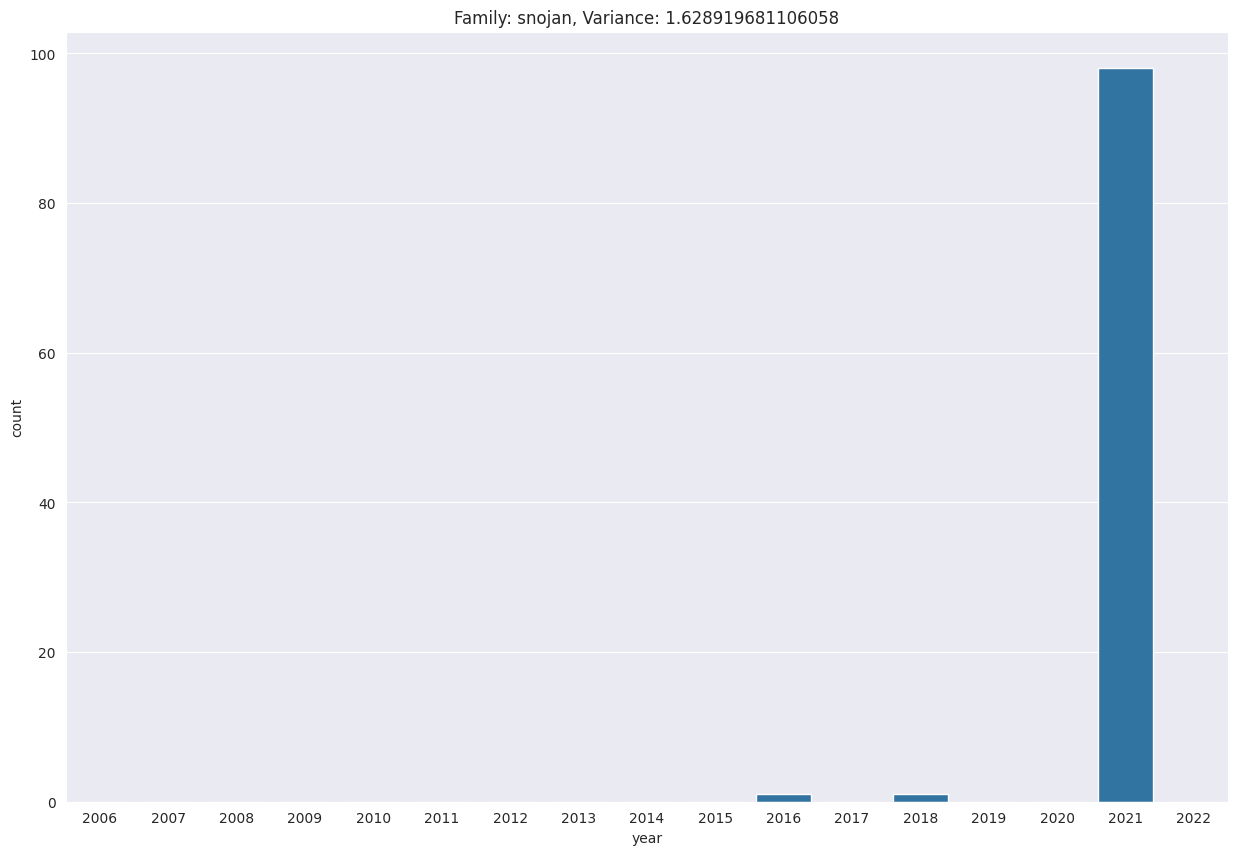

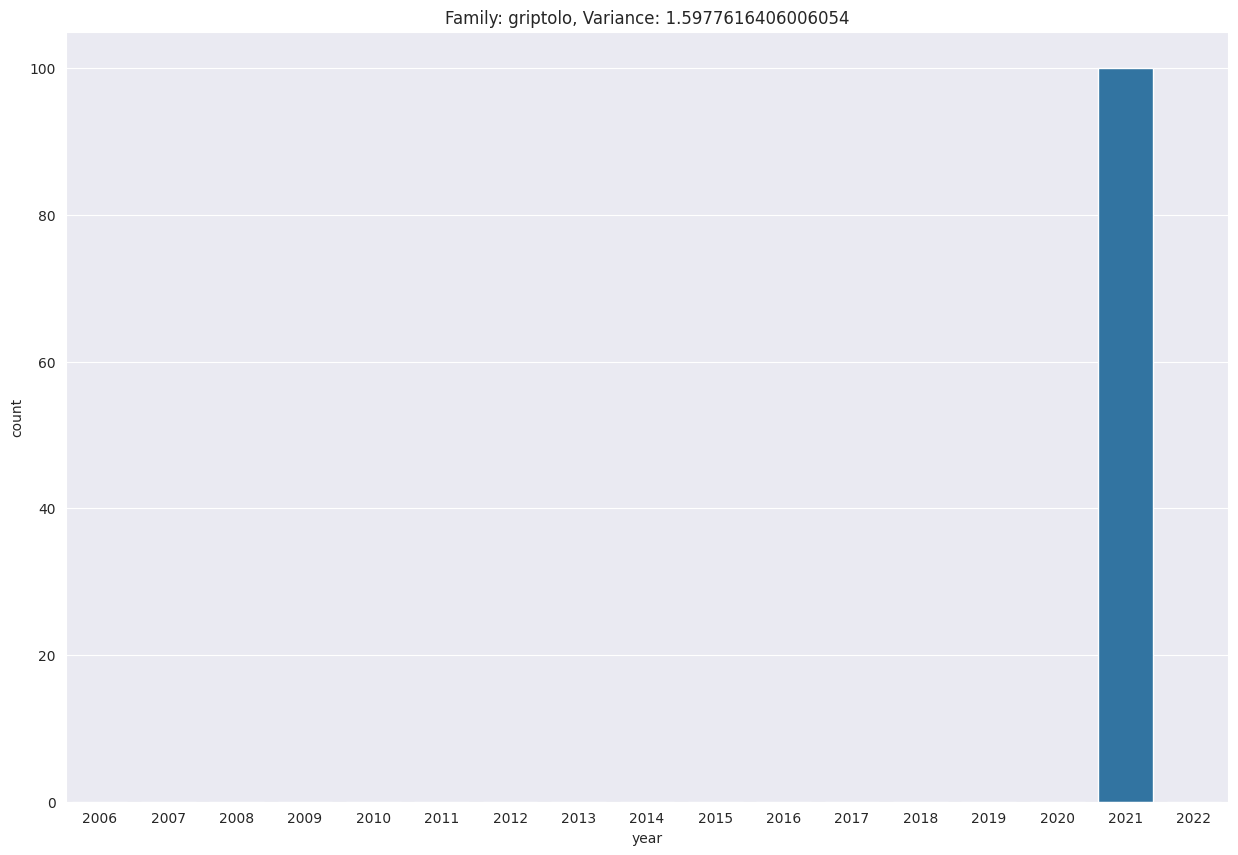

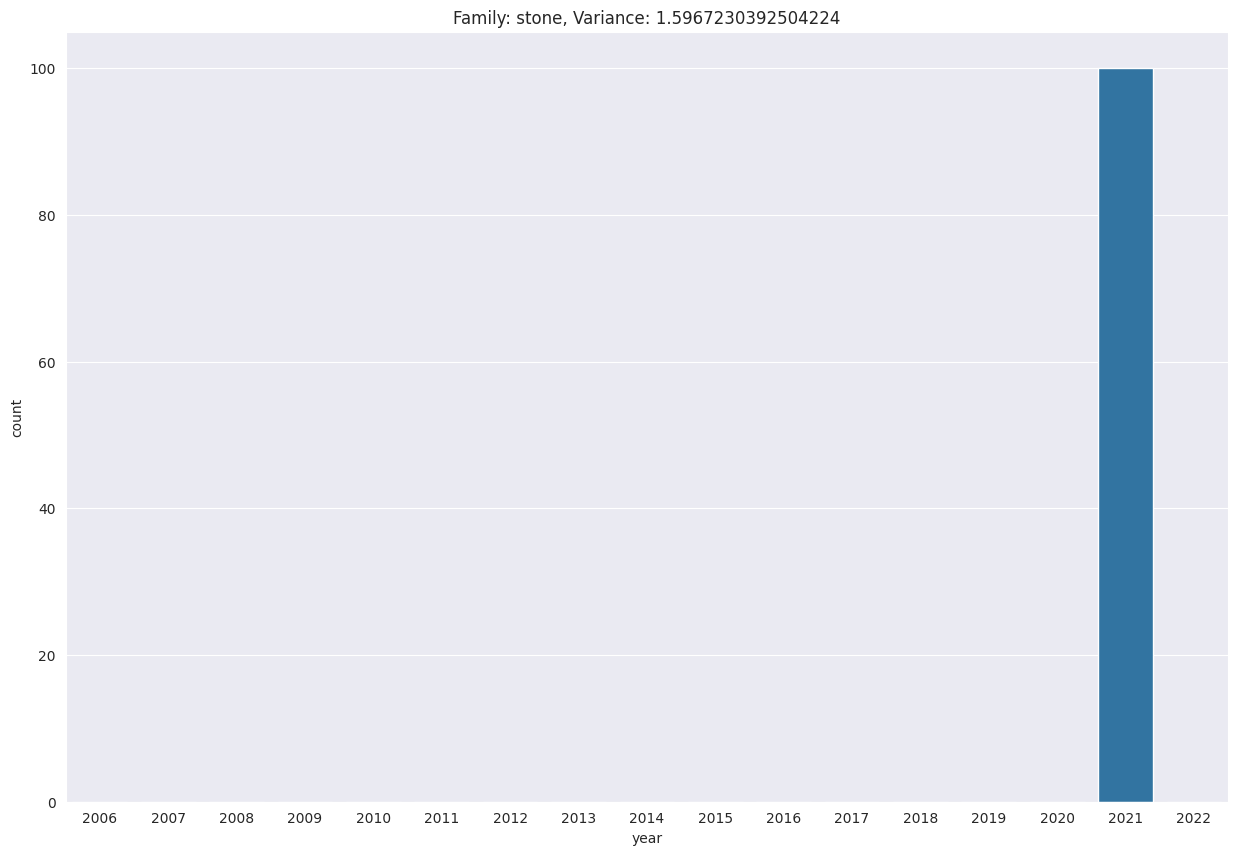

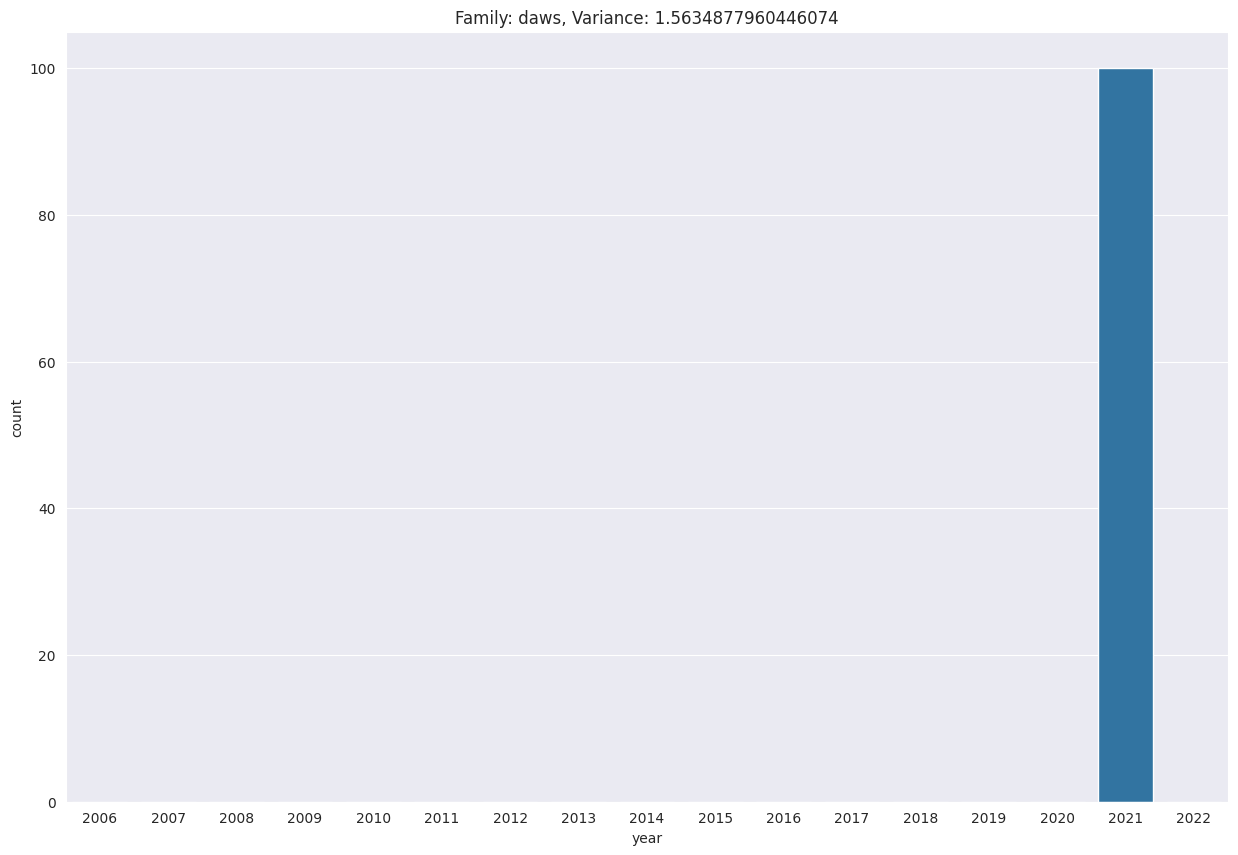

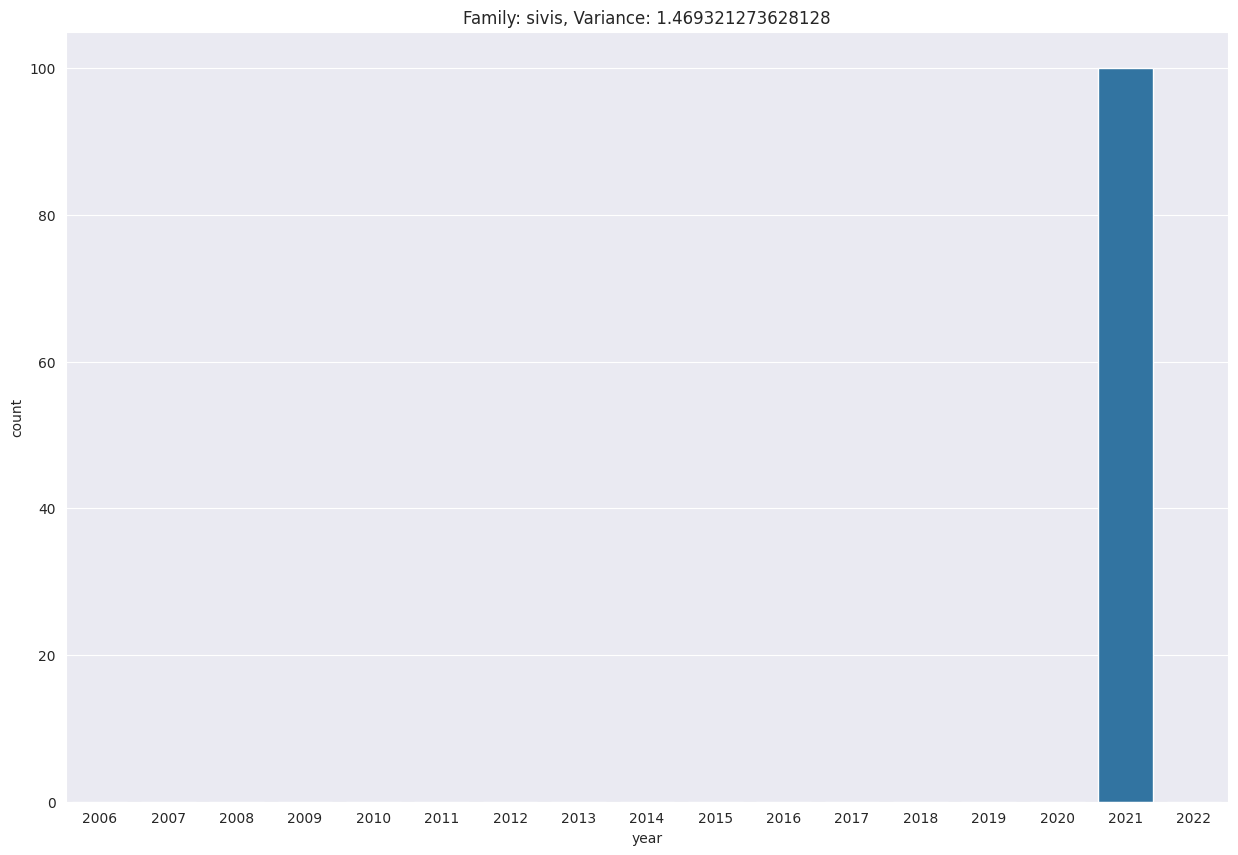

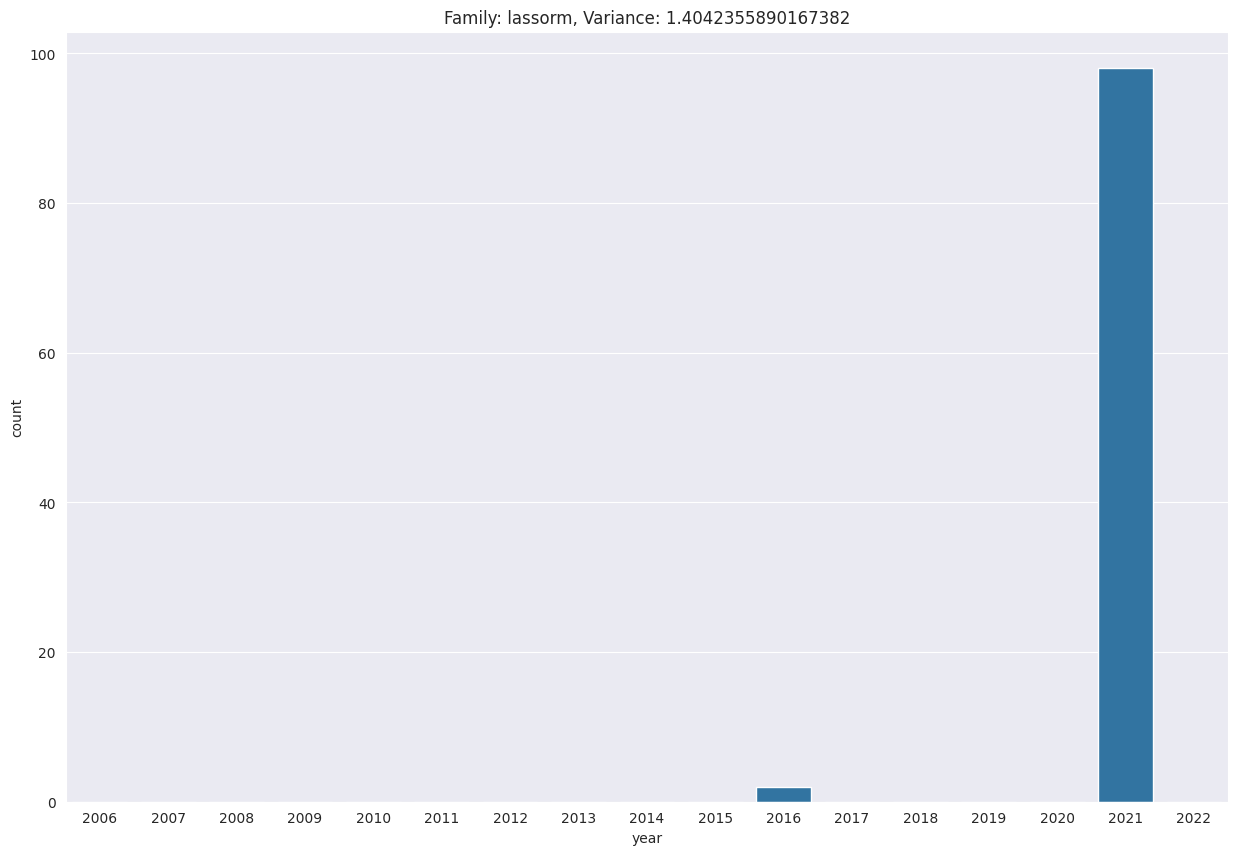

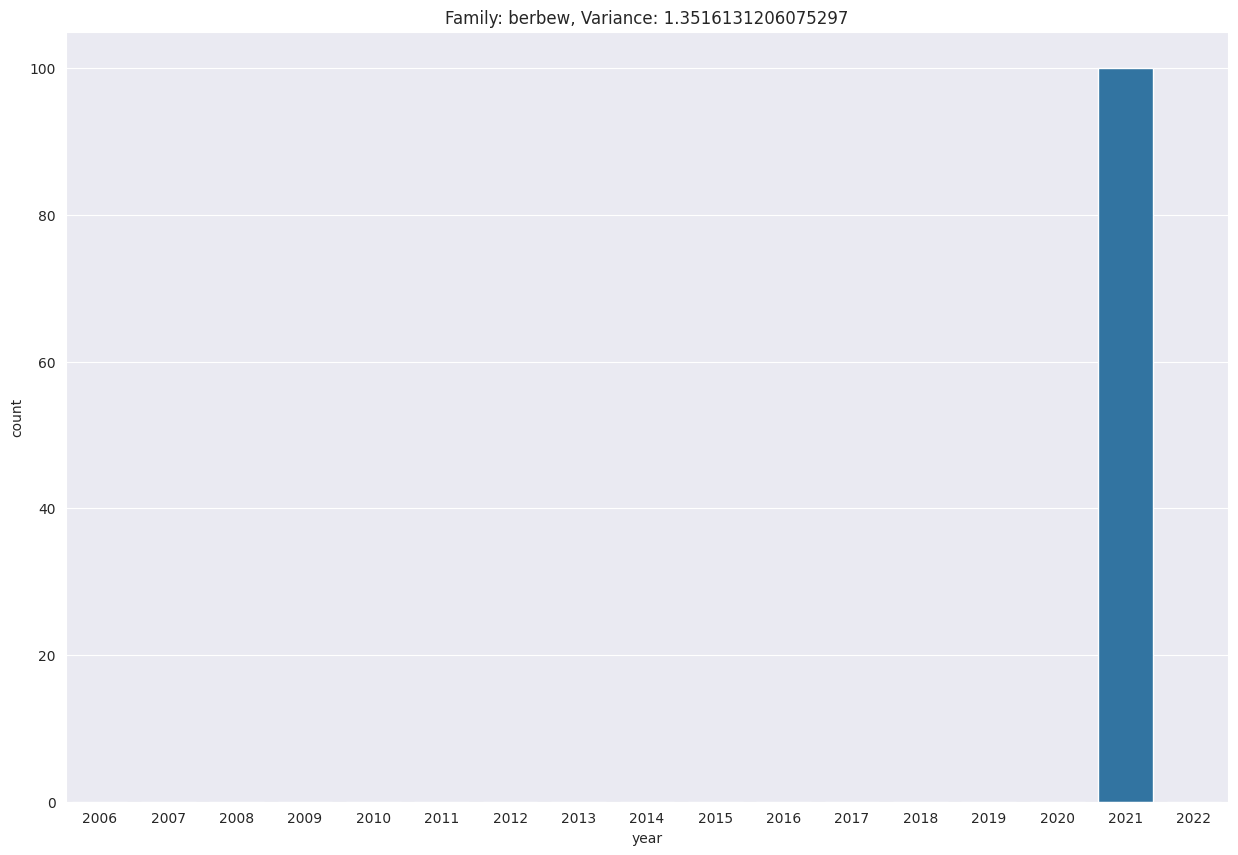

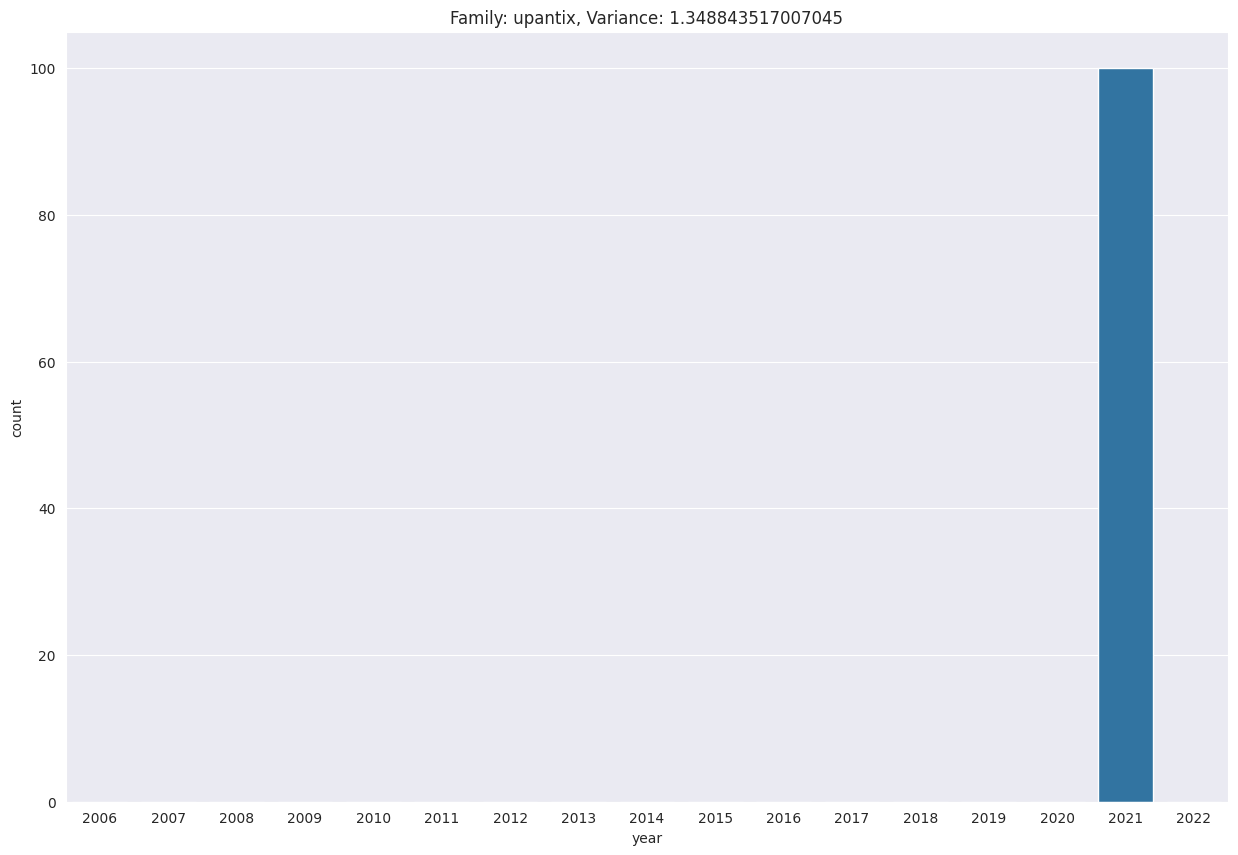

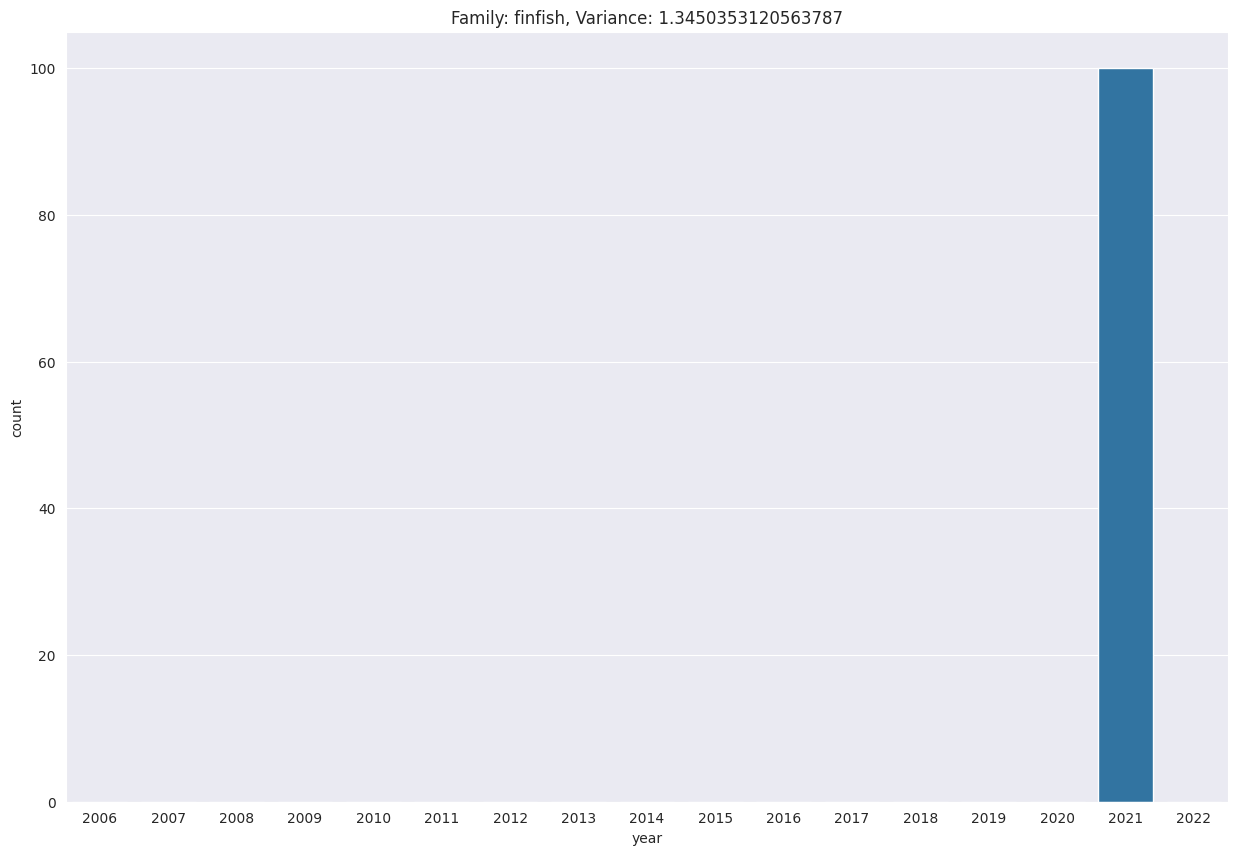

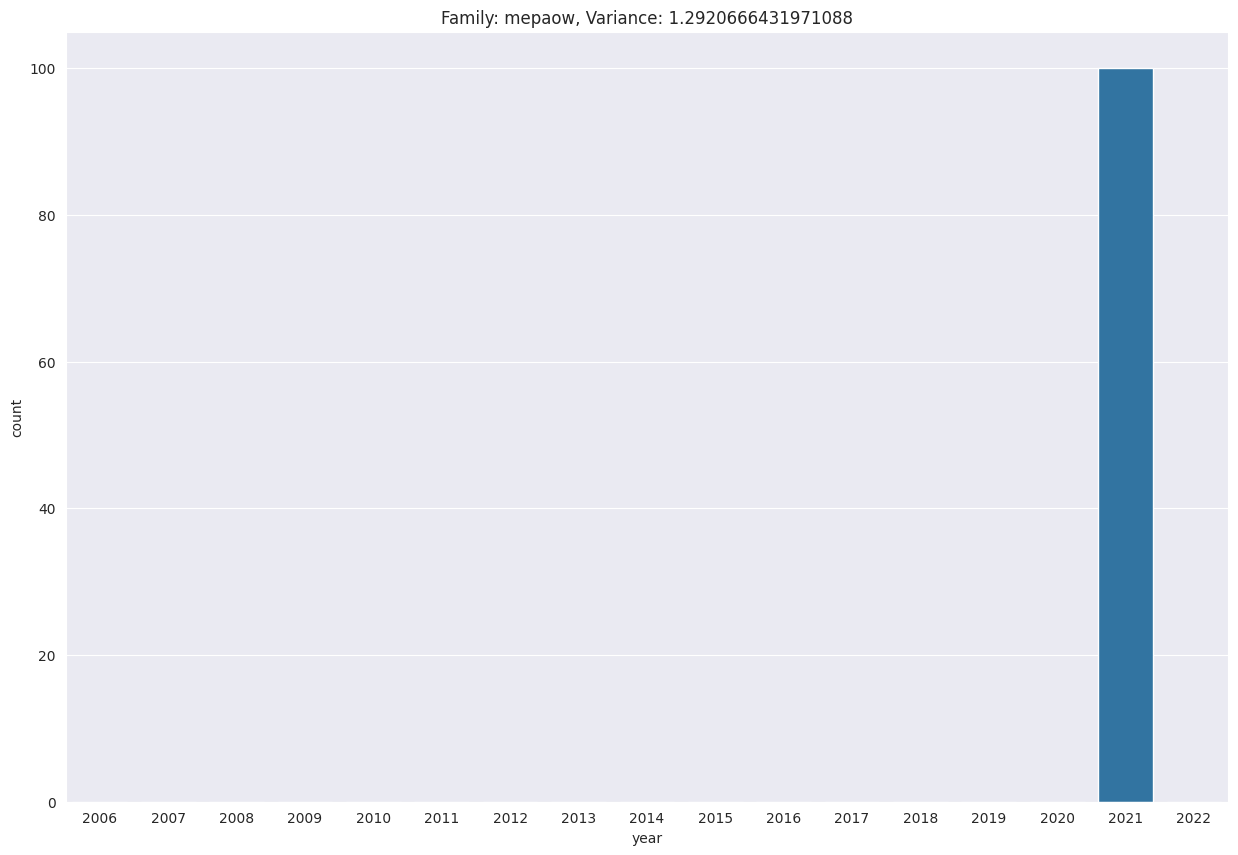

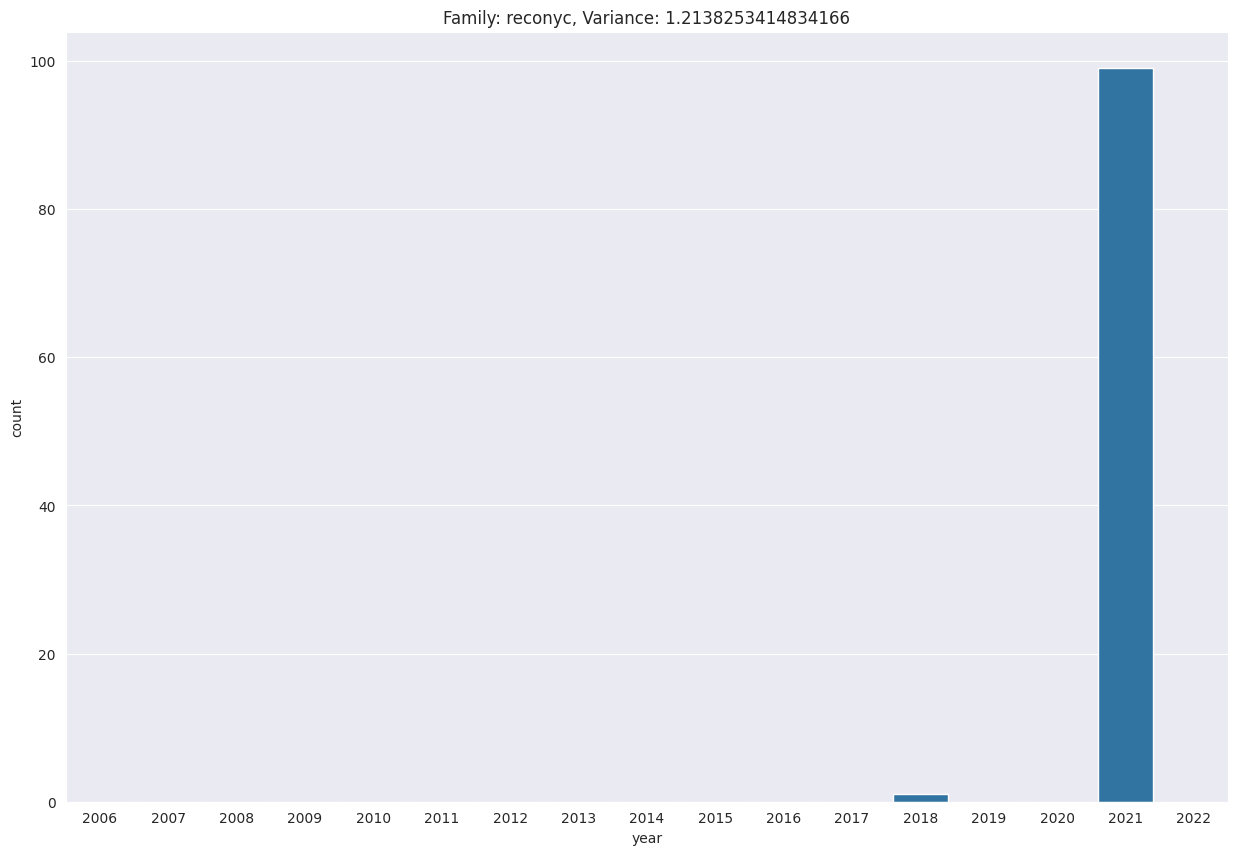

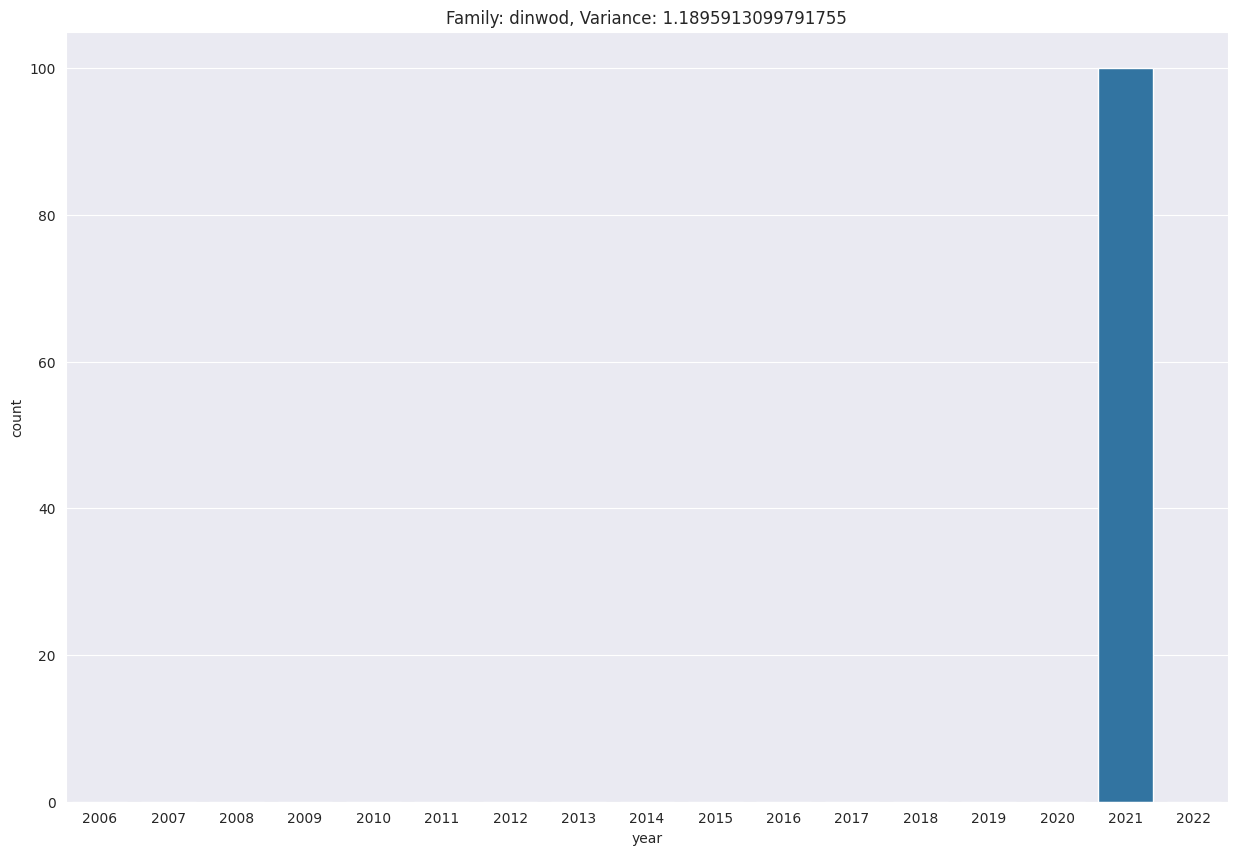

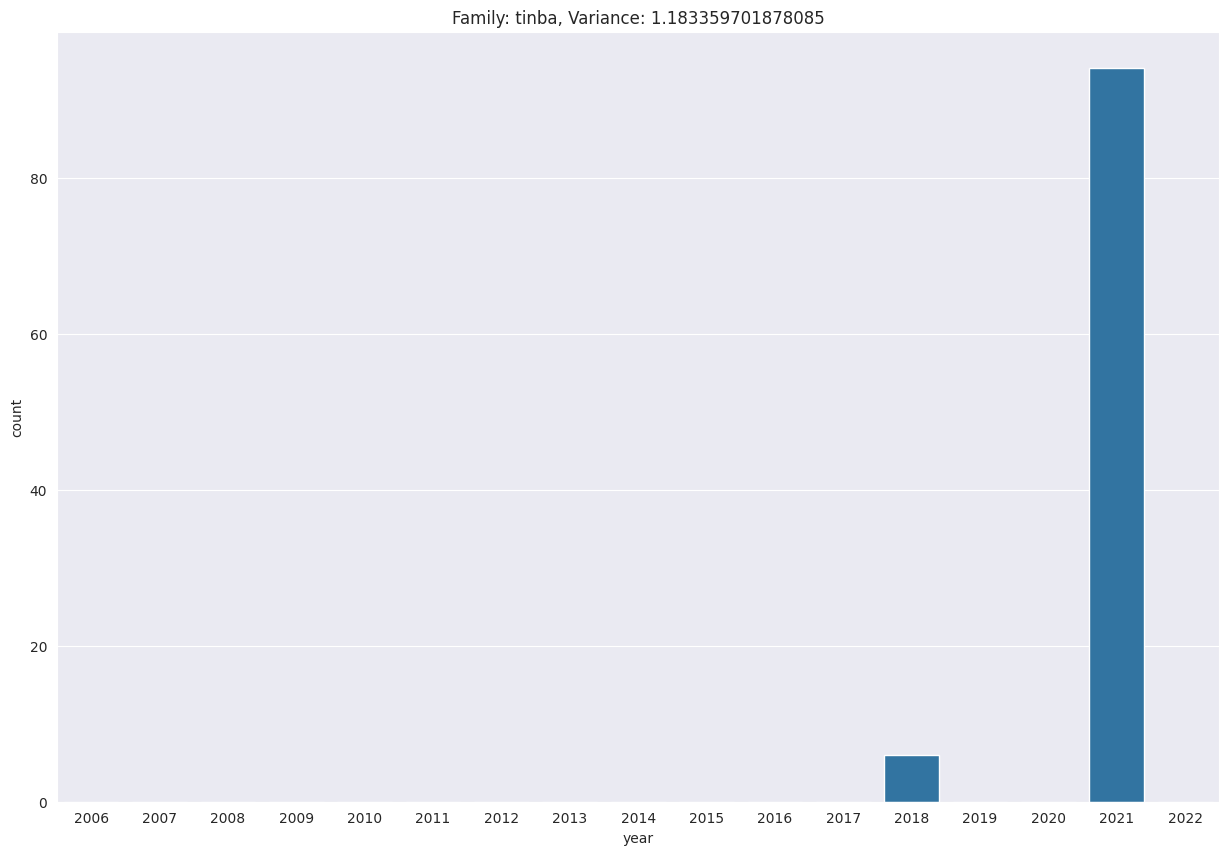

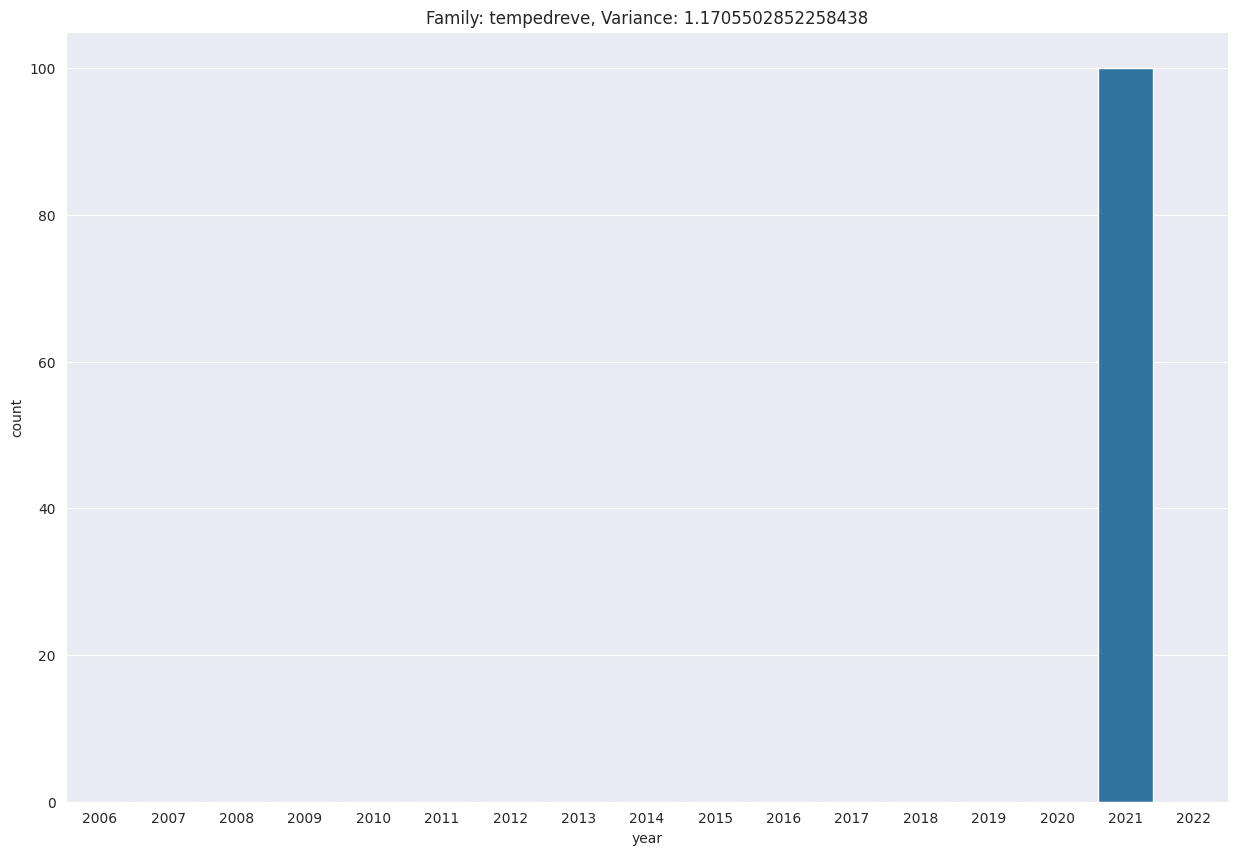

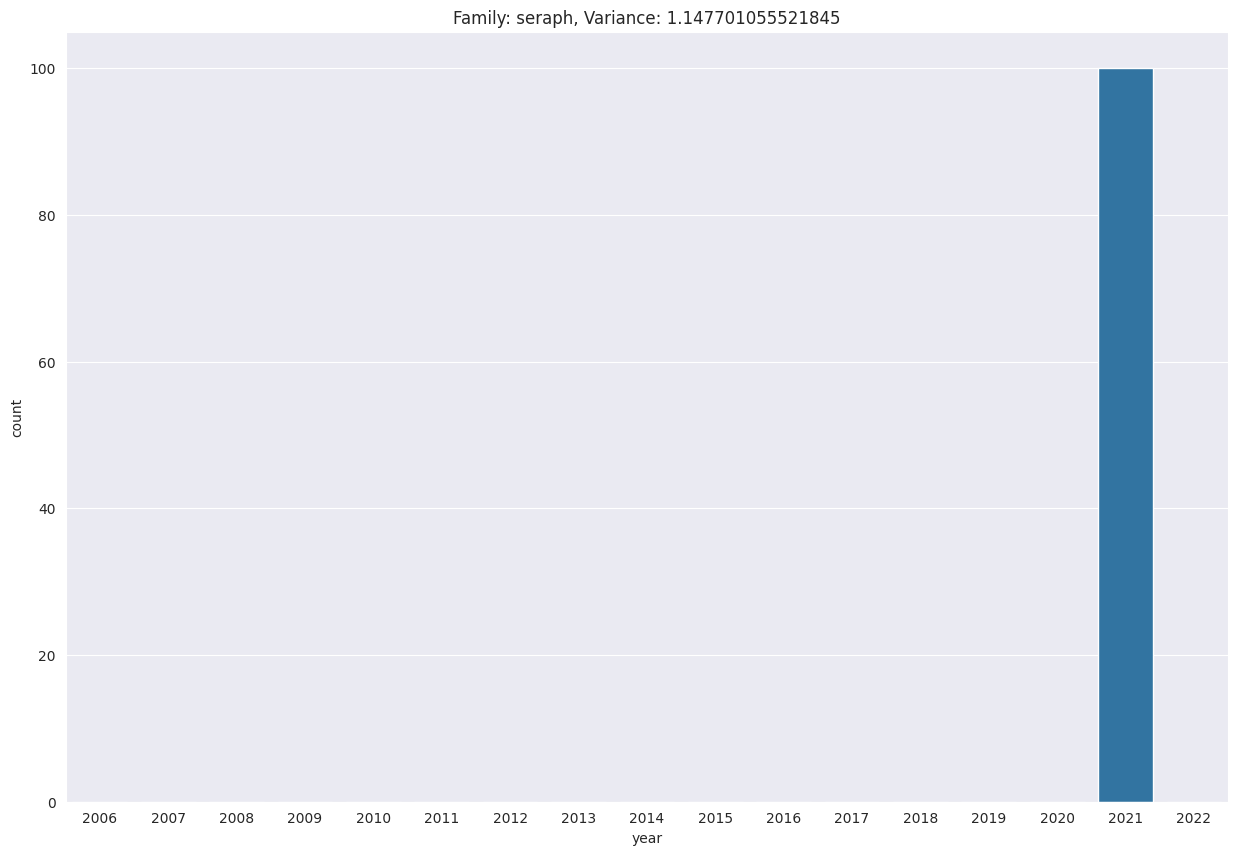

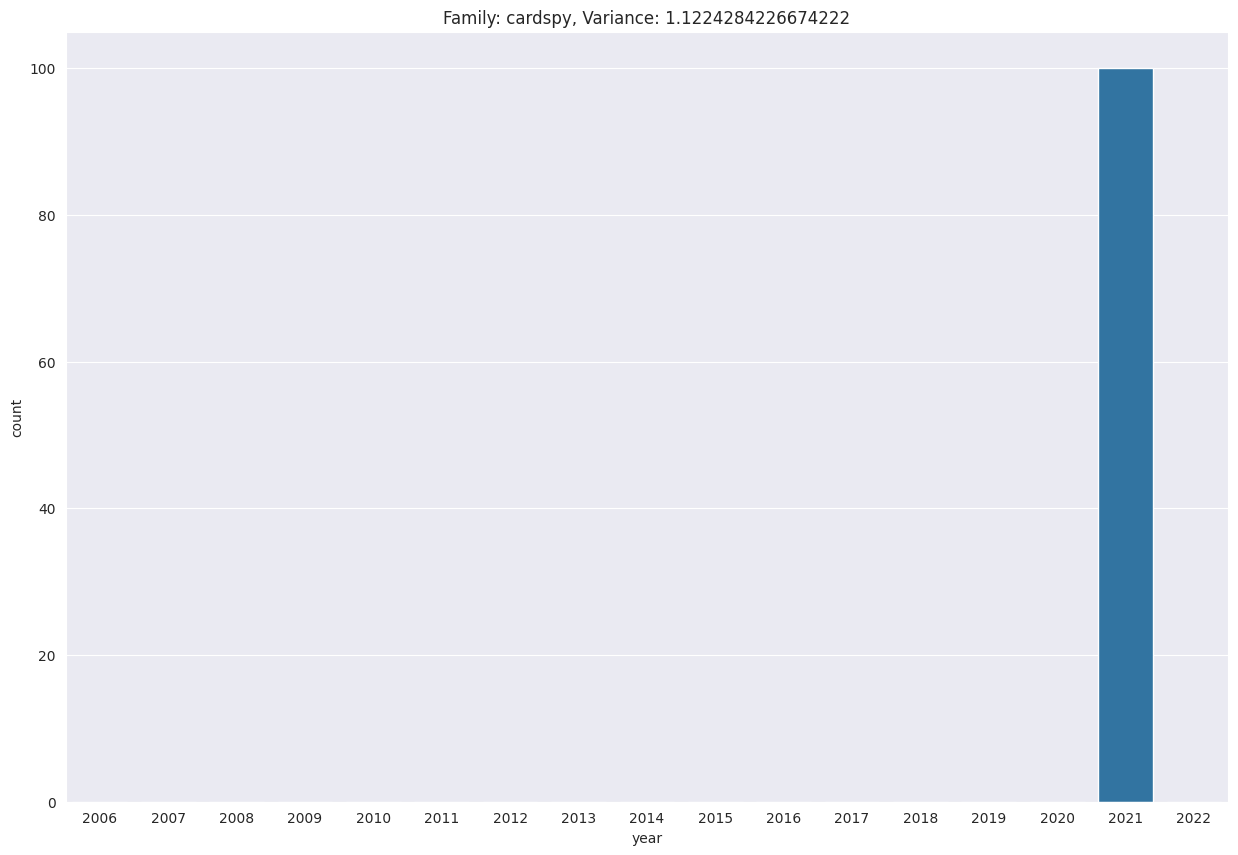

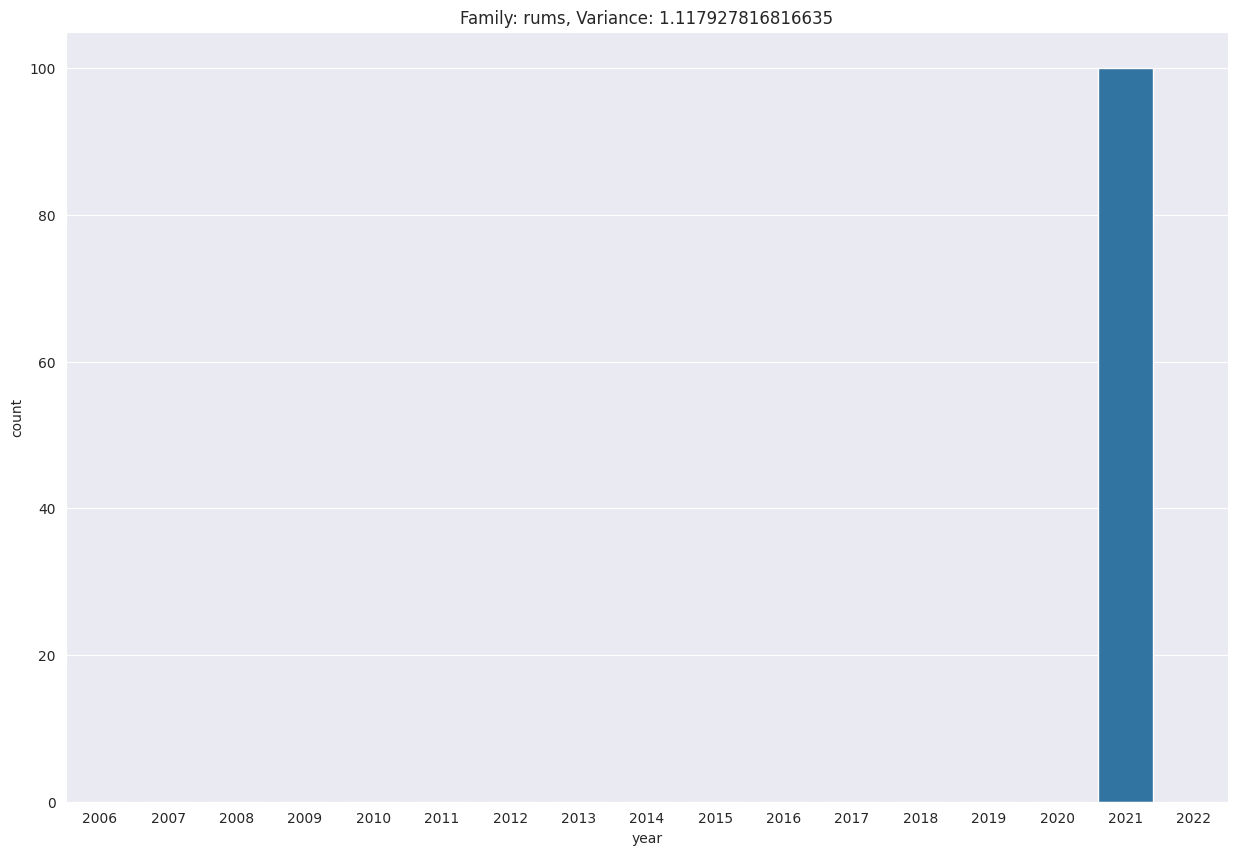

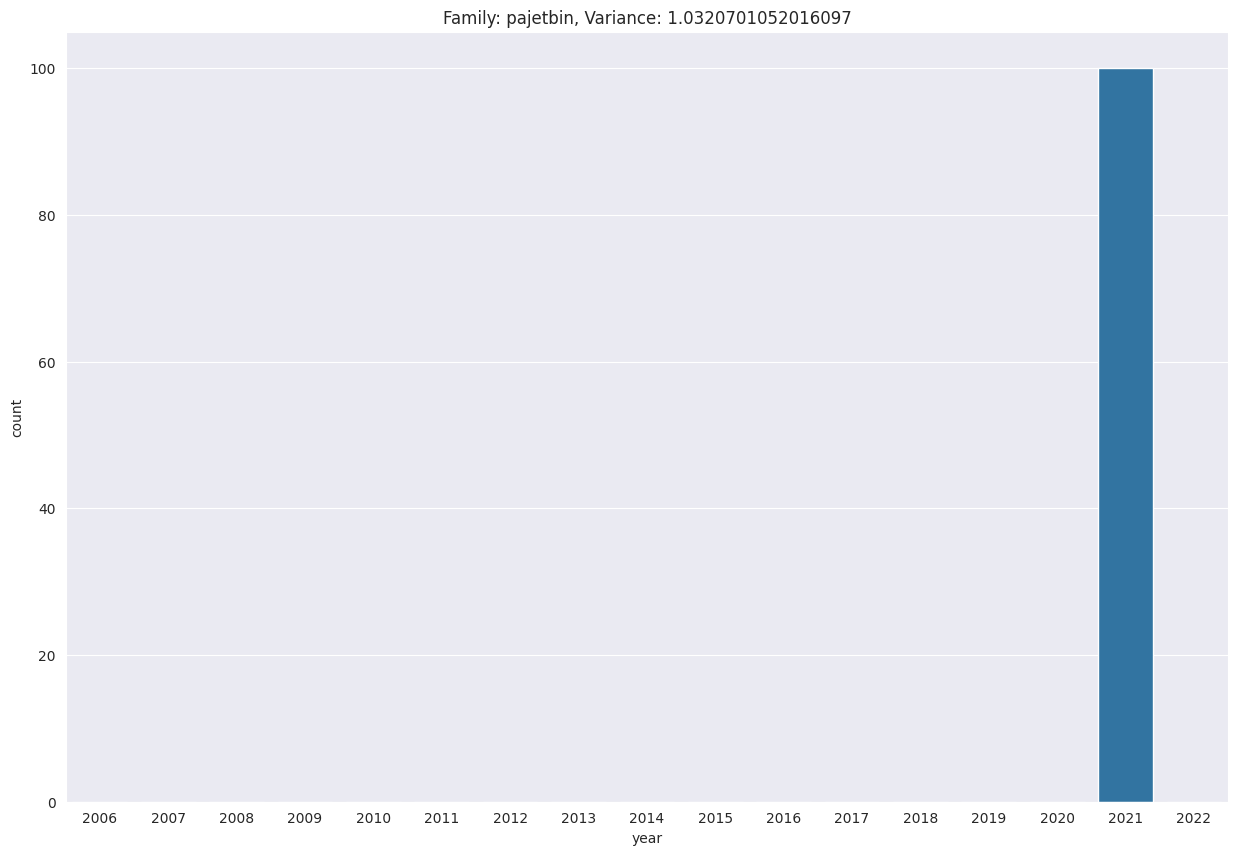

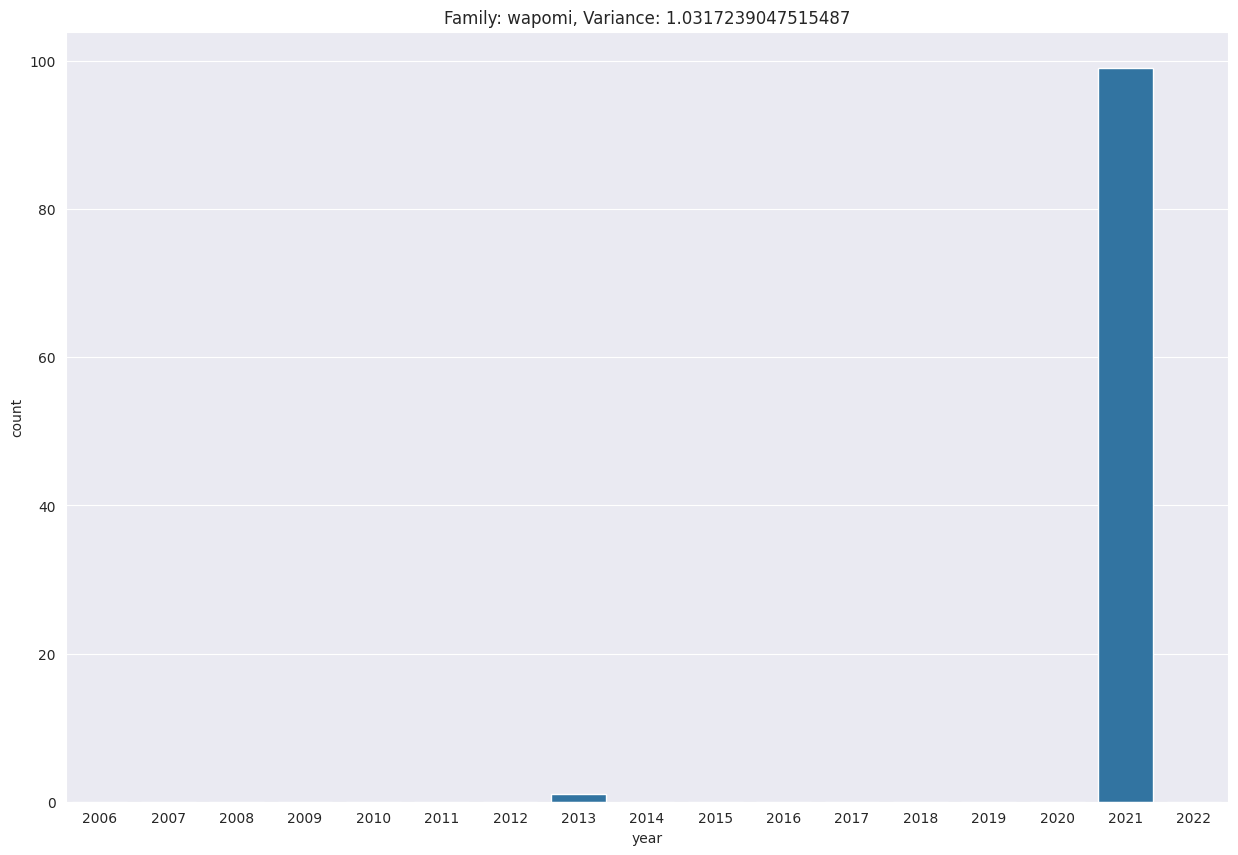

In [269]:
year_min = df_dt["first_submission_date"].min()
year_max = df_dt["first_submission_date"].max()

years_range = range(year_min, year_max + 1) #pd.date_range(start=year_min, end=year_max, freq="Y")
df_dt_1 = df_dt.groupby(by=["family", "first_submission_date"]).size().reset_index(name='count')

for family in families:
    year_count = np.zeros(len(years_range))
    # Get the dataset portion where family is equal to the iteration one.
    family_data = df_dt_1[df_dt_1["family"] == family]
    # From each date compute the offset relative to year_count
    off = [y - year_min for y in family_data["first_submission_date"]]
    # Set each off cell with the respective count
    for index, value in zip(off, family_data["count"]):
        year_count[index] = value

    df_plot = pd.DataFrame({"year": years_range, "count": year_count})
    plt.figure(figsize=(15, 10))
    sns.barplot(data=df_plot, x="year", y="count")
    plt.title(f"Family: {family}, "
              f"Variance: {df_variances_top[df_variances_top['family'] == family]['variance'].iloc[0]}")
    plt.show()

In [270]:
w_avg_timestamps = []

families = df_variances["family"].unique()

for family in families:
    family_data = df_dt_1[df_dt_1["family"] == family]
    timestamps = (family_data["first_submission_date"]
                  .apply(lambda dt: pd.Timestamp(f"{dt}-1-1").timestamp()))
    w_avg = np.average(timestamps, weights=family_data["count"])
    w_avg_timestamps.append(w_avg)
    #print(pd.to_datetime(avg, unit='s'))
    
df_avg_timestamps_f = (pd.DataFrame({"family": families, "w_avg_timestamp": w_avg_timestamps})
                       .sort_values(by="family").reset_index())
df_variances_f = (df_variances[df_variances["family"].isin(families)]
                  .sort_values(by="family").reset_index())

correlation = df_variances_f["variance"].corr(df_avg_timestamps_f["w_avg_timestamp"])
print(f"Variance-Weighted Avg Timestamp correlation: {correlation}")

Variance-Weighted Avg Timestamp correlation: 0.45151555416842226


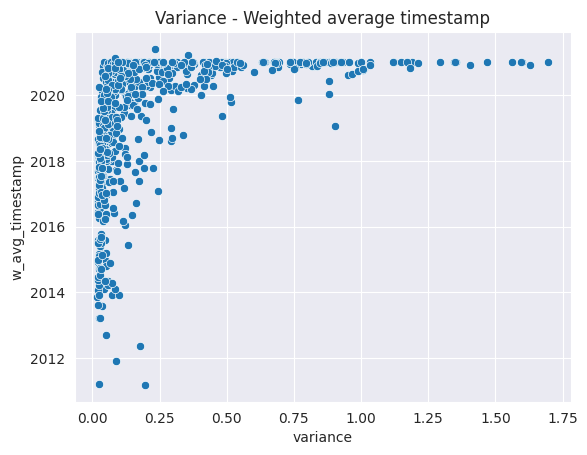

In [271]:
w_avg_datetimes = df_avg_timestamps_f["w_avg_timestamp"].apply(lambda t: pd.to_datetime(t, unit="s"))
sns.scatterplot(x=df_variances_f["variance"], y=w_avg_datetimes)
plt.title("Variance - Weighted average timestamp")
plt.show()